In [1]:
%matplotlib inline

import os, subprocess, tarfile
from glob import glob
import numpy as np
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy
import cartopy.crs as ccrs
import scipy.stats as stats
from scipy.io import loadmat

import warnings
warnings.filterwarnings('ignore')

# Generate Paths

In [2]:
file_path = '/archive/Lori.Sentman/fre/ESM4.2_2021.03_chem_updates_MOM6up/ESM4p2_piControl_spinup_lowss_WOAinitCond/gfdl.ncrc4-intel18-prod-openmp/pp'
diagType1 = 'ocean_cobalt_omip_tracers_year_z'
diagType2 = 'ocean_cobalt_omip_2d'

num_years = 25
years = ['0476-0480', '0481-0485', '0486-0490', '0491-0495', '0496-0500']

In [3]:
# using python's list comprehension and path/string join method to put together the appropriate paths
dot = '.'
dic_var = 'dissic'
dic_file_prefix = os.path.join(file_path, diagType1, 'ts', 'annual', '5yr/')
dic_files = [dot.join([dic_file_prefix + diagType1, yy, dic_var, 'nc']) for yy in years]
# print(dic_files)

talk_var = 'talk'
talk_file_prefix = os.path.join(file_path, diagType1, 'ts', 'annual', '5yr/')
talk_files = [dot.join([talk_file_prefix + diagType1, yy, talk_var, 'nc']) for yy in years]
# print(talk_files)

ph_var = 'ph'
ph_file_prefix = os.path.join(file_path, diagType1, 'ts', 'annual', '5yr/')
ph_files = [dot.join([ph_file_prefix + diagType1, yy, ph_var, 'nc']) for yy in years]
# print(ph_files)

spco2_var = 'spco2'
spco2_file_prefix = os.path.join(file_path, diagType2, 'ts', 'annual', '5yr/')
spco2_files = [dot.join([spco2_file_prefix + diagType2, yy, spco2_var, 'nc']) for yy in years]
# print(spco2_files)

fgco2_var = 'fgco2'
fgco2_file_prefix = os.path.join(file_path, diagType2, 'ts', 'annual', '5yr/')
fgco2_files = [dot.join([fgco2_file_prefix + diagType2, yy, fgco2_var, 'nc']) for yy in years]
# print(fgco2_files)

In [4]:
grid_file = file_path + '/ocean_annual/ocean_annual.static.nc'
grid = xr.open_dataset(grid_file)

# Read in Data

## Dissolved Inorganic Carbon

In [5]:
# Model
# only select surface layer for the 3d variables
ds_dic = xr.open_mfdataset(dic_files, combine='by_coords')
ds_dic = ds_dic.sel(z_l=2.5)
# convert from mol m-3 to mmoles m-3
ds_dic['dissic'].values = ds_dic.dissic.values*1000
ds_dic.dissic.attrs['units'] = 'mmol m-3'

In [6]:
# Observations
# TCO2 data, remapped from GLODAP
# units are micromoles per kg, convert to mmoles per m^3 using 1035/1000
dic_obs_file = '/work/jyl/proj/ESM4.2_COBALT/COBALT_diagnostics/Remapped_Data/TCO2_glodap_esm4grid.nc'
dic_obs = xr.open_dataset(dic_obs_file)
dic_obs = dic_obs.sel(z_l=2.5)
dic_obs['TCO2_glodap'].values = dic_obs.TCO2_glodap.values * 1035./1000.

## Total Alkalinity

In [7]:
# Model
ds_talk = xr.open_mfdataset(talk_files, combine='by_coords')
ds_talk = ds_talk.sel(z_l=2.5)
# convert from mol m-3 to mmoles m-3
ds_talk['talk'].values = ds_talk['talk'].values*1000
ds_talk.talk.attrs['units'] = 'mmol m-3'

In [8]:
# Observations
# Alkalinity data, remapped from GLODAP 
# units are micromoles per kg, convert to mmoles m^3 using 1035/1000
alk_obs_file = '/work/jyl/proj/ESM4.2_COBALT/COBALT_diagnostics/Remapped_Data/TAlk_glodap_esm4grid.nc'
alk_obs = xr.open_dataset(alk_obs_file)
alk_obs = alk_obs.sel(z_l=2.5)
alk_obs['TAlk_glodap'].values = alk_obs['TAlk_glodap'].values * 1035./1000.

## pH

In [9]:
# Model
ds_ph = xr.open_mfdataset(ph_files, combine='by_coords')
ds_ph = ds_ph.sel(z_l=2.5)

In [10]:
# Observations
# pH data, remapped from GLODAP 
ph_obs_file = '/work/jyl/proj/ESM4.2_COBALT/COBALT_diagnostics/Remapped_Data/pH_glodap_esm4grid.nc'
ph_obs = xr.open_dataset(ph_obs_file)
ph_obs = ph_obs.sel(z_l=2.5)

## Surface pCO2

In [11]:
# Model
ds_spco2 = xr.open_mfdataset(spco2_files, combine='by_coords')
# convert from Pascals to microatmospheres for easier comparison with ppm
# 1 atm = 1.01325 x 10^5 Pa; 1 microAtm = 0.101325 Pa; 
ds_spco2['spco2'].values = ds_spco2['spco2'].values * 1e6/1.0133e5
ds_spco2.spco2.attrs['units'] = 'micro-atm'

In [12]:
# Surface pCO2 observations

# From Landschutzer et al. units are in micro-atmopheres, do not convert
spco2_obs_file = '/work/jyl/proj/ESM4.2_COBALT/COBALT_diagnostics/Remapped_Data/spco2_smoothed_monthclim_landschutzer_1992to2012_esm4grid.nc'
spco2_obs = xr.open_dataset(spco2_obs_file)
spco2_obs = spco2_obs.mean(dim='time')

## Air-sea CO2 flux

In [13]:
# Model
# CO2 flux
# convert fgco2 kg m^-2 sec-1, to grams per m^-2 yr^-1
ds_fgco2 = xr.open_mfdataset(fgco2_files, combine='by_coords')
ds_fgco2['fgco2'].values = ds_fgco2['fgco2'].values * 1000 * 86400 * 365

In [14]:
# Observations

# From Landschutzer
# units are in moles per m^2 yr^-1; convert to grams per m^2 yr^-1;
# multiply by negative 1 to make positive into the ocean
fgco2_obs_file = '/work/jyl/proj/ESM4.2_COBALT/COBALT_diagnostics/Remapped_Data/fgco2_smoothed_monthclim_landschutzer_1992to2012_esm4grid.nc'
fgco2_obs = xr.open_dataset(fgco2_obs_file)
fgco2_obs['fgco2_smoothed_monthclim_landschutzer_1992to2012'].values = \
fgco2_obs['fgco2_smoothed_monthclim_landschutzer_1992to2012'].values * 12 * -1
fgco2_obs = fgco2_obs.mean(dim='time')

### Select appropriate time dimensions

In [15]:
# # Average over the appropriate time scale for comparison
# # 1992-2012 for GLODAP comparison, use the same for Landschutzer
# # Confirm the right time slices
# print('For GLODAP/Landschutzer comparison, selecting from ' + str(ds_dic.isel(time=slice(2,23))['time.year'].min().values) + ' to ' + \
#       str(ds_dic.isel(time=slice(2,23))['time.year'].max().values))

# ds_dic = ds_dic.isel(time=slice(2,23)).mean(dim='time')
# ds_talk = ds_talk.isel(time=slice(2,23)).mean(dim='time')
# ds_ph = ds_ph.isel(time=slice(2,23)).mean(dim='time')
# ds_spco2 = ds_spco2.isel(time=slice(2,23)).mean(dim='time')

# print('For Gruber comparison, selecting from ' + str(ds_fgco2.isel(time=slice(4,18))['time.year'].min().values) + ' to ' + \
#       str(ds_fgco2.isel(time=slice(4,18))['time.year'].max().values))
# ds_fgco2['fgco2_gruber'] = ds_fgco2.fgco2.isel(time=slice(4,18)).mean(dim='time')

# ds_fgco2 = ds_fgco2.isel(time=slice(2,23)).mean(dim='time')


In [16]:
ds_dic = ds_dic.mean(dim='time')
ds_talk = ds_talk.mean(dim='time')
ds_ph = ds_ph.mean(dim='time')
ds_spco2 = ds_spco2.mean(dim='time')
ds_fgco2 = ds_fgco2.mean(dim='time')

# Evaluate Skill Metrics

In [17]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def rmse_diffs(differences):
    return np.sqrt(np.sum((differences ** 2)/len(differences)))

In [18]:
def log_differences(ds1, ds2, minimum=0.1):
    if(len(ds1) != len(ds2)):
        print('ERROR: Arrays are not the same length')
        return NULL
    array_length=len(ds1)
    min_array = np.repeat(minimum,array_length)
    
    log_ds1 = np.log10(np.maximum(ds1, min_array))
    log_ds2 = np.log10(np.maximum(ds2, min_array))
    
    return log_ds1 - log_ds2

In [19]:
X=ds_dic.dissic.stack(z=('xh','yh')).values
Y=dic_obs.TCO2_glodap.stack(z=('xh','yh')).values
mask = np.logical_and(~np.isnan(X),~np.isnan(Y))

ma_len = len(X[mask])
res1_dic = X[mask] - Y[mask]
res2_dic = log_differences(X[mask],Y[mask],minimum=0.1)
skew1_dic = stats.skew(res1_dic)
skew2_dic = stats.skew(res2_dic)
res_dic = res1_dic
r_dic = stats.pearsonr(X[mask],Y[mask])[0]
rmse_dic = rmse_diffs(res_dic)
bias_dic = np.mean(res_dic)

In [20]:
X=ds_talk.talk.stack(z=('xh','yh')).values
Y=alk_obs.TAlk_glodap.stack(z=('xh','yh')).values
mask = np.logical_and(~np.isnan(X),~np.isnan(Y))

ma_len = len(X[mask])
res1_alk = X[mask] - Y[mask]
res2_alk = log_differences(X[mask],Y[mask],minimum=0.01)
skew1_alk = stats.skew(res1_alk)
skew2_alk = stats.skew(res2_alk)
res_alk = res1_alk
r_alk = stats.pearsonr(X[mask],Y[mask])[0]
rmse_alk = rmse_diffs(res_alk)
bias_alk = np.mean(res_alk)

In [21]:
X=ds_ph.ph.stack(z=('xh','yh')).values
Y=ph_obs.pH_glodap.stack(z=('xh','yh')).values
mask = np.logical_and(~np.isnan(X),~np.isnan(Y))

ma_len = len(X[mask])
res1_ph = X[mask] - Y[mask]
res2_ph = log_differences(X[mask],Y[mask],minimum=0.01)
skew1_ph = stats.skew(res1_ph)
skew2_ph = stats.skew(res2_ph)
res_ph = res1_ph
r_ph = stats.pearsonr(X[mask],Y[mask])[0]
rmse_ph = rmse_diffs(res_ph)
bias_ph = np.mean(res_ph)

In [22]:
X=ds_spco2.spco2.stack(z=('xh','yh')).values
Y=spco2_obs.spco2_smoothed_monthclim_landschutzer_1992to2012.stack(z=('xh','yh')).values
mask = np.logical_and(~np.isnan(X),~np.isnan(Y))

ma_len = len(X[mask])
res1_spco2 = X[mask] - Y[mask]
res2_spco2 = log_differences(X[mask],Y[mask],minimum=0.01)
skew1_spco2 = stats.skew(res1_spco2)
skew2_spco2 = stats.skew(res2_spco2)
res_spco2 = res1_spco2
r_spco2 = stats.pearsonr(X[mask],Y[mask])[0]
rmse_spco2 = rmse_diffs(res_spco2)
bias_spco2 = np.mean(res_spco2)

In [23]:
X=ds_fgco2.fgco2.stack(z=('xh','yh')).values
Y=fgco2_obs.fgco2_smoothed_monthclim_landschutzer_1992to2012.stack(z=('xh','yh')).values
mask = np.logical_and(~np.isnan(X),~np.isnan(Y))

ma_len = len(X[mask])
res1_fgco2 = X[mask] - Y[mask]
res2_fgco2 = log_differences(X[mask],Y[mask],minimum=0.01)
skew1_fgco2 = stats.skew(res1_fgco2)
skew2_fgco2 = stats.skew(res2_fgco2)
res_fgco2 = res1_fgco2
r_fgco2 = stats.pearsonr(X[mask],Y[mask])[0]
rmse_fgco2 = rmse_diffs(res_fgco2)
bias_fgco2 = np.mean(res_fgco2)

In [24]:
# Calculate additional metrics (quoted in paper)
fgco2_net_mod = (ds_fgco2.fgco2 * grid.areacello).sum() / 1e15
fgco2_net_obs = (fgco2_obs.fgco2_smoothed_monthclim_landschutzer_1992to2012 * grid.areacello).sum() / 1e15
fgco2_net_mod_gruber = (ds_fgco2.fgco2 * grid.areacello).sum() / 1e15

In [25]:
print("Simulated net air-sea flux between 1994-2007 is: " + str(np.round(fgco2_net_mod_gruber.values,2)) + " Pg C yr-1")

Simulated net air-sea flux between 1994-2007 is: 0.12 Pg C yr-1


# Plot

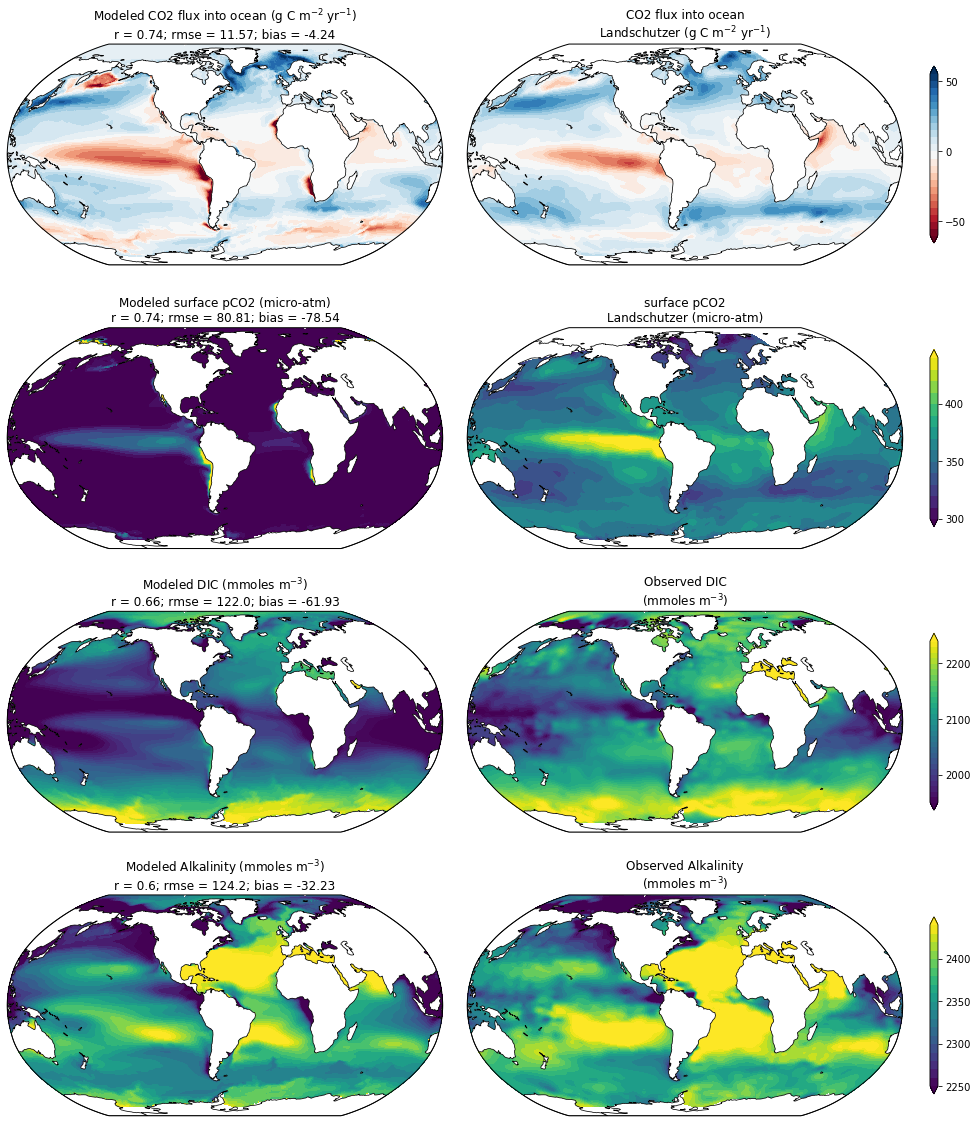

In [31]:
fig=plt.figure(figsize=(18,20))
gs=gridspec.GridSpec(4,2, wspace=0.05, width_ratios=[1,1.25])

ax={};cs={}

fs = 12 #fontsize

###########################################################################
# fgco2                                                                   #
###########################################################################
cmin=-60; cmax=60; cint=5
levels=np.arange(cmin,cmax,cint)

i=0
ax[i]=plt.subplot(gs[0,0],projection=ccrs.Robinson(central_longitude=300.0))
field=ds_fgco2.fgco2
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=levels, cmap='RdBu', extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
#cbar=plt.colorbar(cs[i], ticks=[-50,0,50])
ax[i].set_title('Modeled CO2 flux into ocean (g C m$^{-2}$ yr$^{-1}$)\nr = ' + str(np.round(r_fgco2,2)) + \
                 '; rmse = ' + str(np.round(rmse_fgco2,2)) + \
                 '; bias = ' + str(np.round(bias_fgco2,2)), fontsize=fs)

i=1
ax[i]=plt.subplot(gs[0,1],projection=ccrs.Robinson(central_longitude=300.0))
field=fgco2_obs.fgco2_smoothed_monthclim_landschutzer_1992to2012
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=levels, cmap='RdBu', extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('CO2 flux into ocean\nLandschutzer (g C m$^{-2}$ yr$^{-1}$)', fontsize=fs)

cbar=plt.colorbar(cs[i], ticks=[-50,0,50], shrink=0.75)

###########################################################################
# spco2                                                                   #
###########################################################################

cmin = 300; cmax = 450; cint=10
levels=np.arange(cmin,cmax,cint)

i=2
ax[i]=plt.subplot(gs[1,0],projection=ccrs.Robinson(central_longitude=300.0))
field=ds_spco2.spco2
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=levels, extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
#cbar=plt.colorbar(cs[i], ticks=[-50,0,50])
ax[i].set_title('Modeled surface pCO2 (micro-atm)\nr = ' + str(np.round(r_spco2,2)) + \
                 '; rmse = ' + str(np.round(rmse_spco2,2)) + \
                 '; bias = ' + str(np.round(bias_spco2,2)), fontsize=fs)

i=3
ax[i]=plt.subplot(gs[1,1],projection=ccrs.Robinson(central_longitude=300.0))
field=spco2_obs.spco2_smoothed_monthclim_landschutzer_1992to2012
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=levels, extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('surface pCO2\nLandschutzer (micro-atm)', fontsize=fs)

cbar=plt.colorbar(cs[i], ticks=[300,350,400,450], shrink=0.75)

###########################################################################
# DIC                                                                     #
###########################################################################

cmin = 1950; cmax = 2250; cint = 10;
levels=np.arange(cmin,cmax,cint)

i=4
ax[i]=plt.subplot(gs[2,0],projection=ccrs.Robinson(central_longitude=300.0))
field=ds_dic.dissic
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=levels, extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
#cbar=plt.colorbar(cs[i], ticks=[-50,0,50])
ax[i].set_title('Modeled DIC (mmoles m$^{-3}$)\nr = ' + str(np.round(r_dic,2)) + \
                 '; rmse = ' + str(np.round(rmse_dic,1)) + \
                 '; bias = ' + str(np.round(bias_dic,2)), fontsize=fs)

i=5
ax[i]=plt.subplot(gs[2,1],projection=ccrs.Robinson(central_longitude=300.0))
field=dic_obs.TCO2_glodap
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=levels, extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Observed DIC\n(mmoles m$^{-3}$)', fontsize=fs)

cbar=plt.colorbar(cs[i], ticks=[2000,2100,2200], shrink=0.75)

###########################################################################
# Alkalinity                                                              #
###########################################################################

cmin = 2250; cmax = 2450; cint = 10
levels=np.arange(cmin,cmax,cint)

i=6
ax[i]=plt.subplot(gs[3,0],projection=ccrs.Robinson(central_longitude=300.0))
field=ds_talk.talk
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=levels, extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
#cbar=plt.colorbar(cs[i], ticks=[-50,0,50])
ax[i].set_title('Modeled Alkalinity (mmoles m$^{-3}$)\nr = ' + str(np.round(r_alk,2)) + \
                 '; rmse = ' + str(np.round(rmse_alk,1)) + \
                 '; bias = ' + str(np.round(bias_alk,2)), fontsize=fs)

i=7
ax[i]=plt.subplot(gs[3,1],projection=ccrs.Robinson(central_longitude=300.0))
field=alk_obs.TAlk_glodap
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=levels, extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Observed Alkalinity\n(mmoles m$^{-3}$)', fontsize=fs)

cbar=plt.colorbar(cs[i], ticks=[2250,2300,2350,2400,2450], shrink=0.75)

plt.tight_layout()
fname = 'sfc_co2alk'
plt.savefig('../plots_esm42/'+fname+'.png', dpi=300, bbox_inches='tight')

# Plot with differences

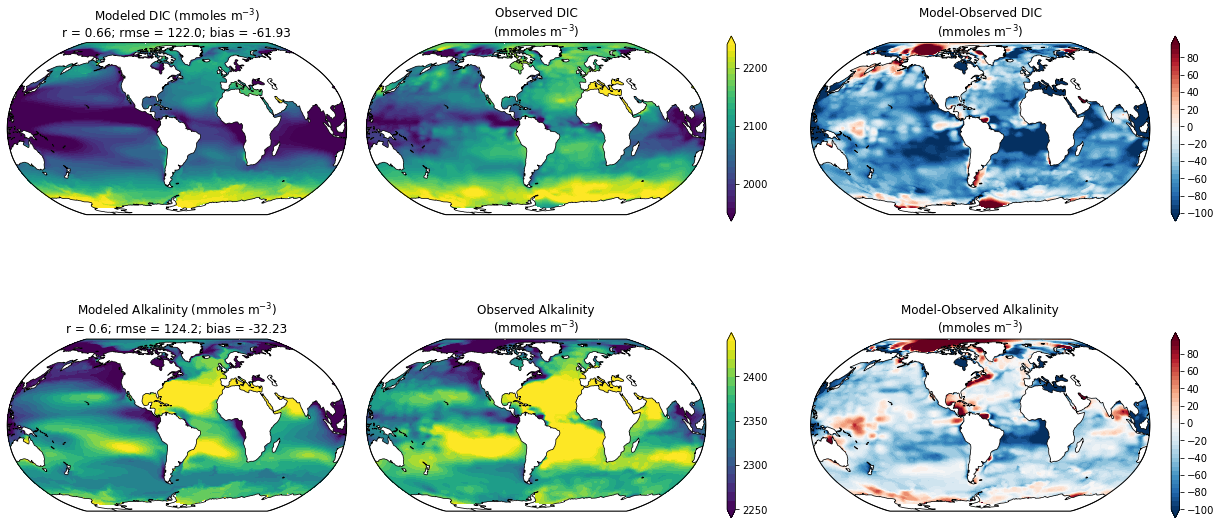

In [28]:
fig=plt.figure(figsize=(22,10))
gs=gridspec.GridSpec(2,3, wspace=0.05, width_ratios=[1,1.25,1.25])

ax={};cs={}

fs = 12 #fontsize

###########################################################################
# DIC                                                                     #
###########################################################################

cmin = 1950; cmax = 2250; cint = 10;
levels=np.arange(cmin,cmax,cint)

i=0
ax[i]=plt.subplot(gs[0,0],projection=ccrs.Robinson(central_longitude=300.0))
field1=ds_dic.dissic
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field1, transform=ccrs.PlateCarree(), levels=levels, extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
#cbar=plt.colorbar(cs[i], ticks=[-50,0,50])
ax[i].set_title('Modeled DIC (mmoles m$^{-3}$)\nr = ' + str(np.round(r_dic,2)) + \
                 '; rmse = ' + str(np.round(rmse_dic,1)) + \
                 '; bias = ' + str(np.round(bias_dic,2)), fontsize=fs)

i=1
ax[i]=plt.subplot(gs[0,1],projection=ccrs.Robinson(central_longitude=300.0))
field2=dic_obs.TCO2_glodap
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field2, transform=ccrs.PlateCarree(), levels=levels, extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Observed DIC\n(mmoles m$^{-3}$)', fontsize=fs)

cbar=plt.colorbar(cs[i], ticks=[2000,2100,2200], shrink=0.75)


i=1
ax[i]=plt.subplot(gs[0,2],projection=ccrs.Robinson(central_longitude=300.0))
field=field1-field2
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=np.arange(-100,100,5), cmap='RdBu_r', extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Model-Observed DIC\n(mmoles m$^{-3}$)', fontsize=fs)

cbar=plt.colorbar(cs[i], shrink=0.75)


###########################################################################
# Alkalinity                                                              #
###########################################################################

cmin = 2250; cmax = 2450; cint = 10
levels=np.arange(cmin,cmax,cint)

i=3
ax[i]=plt.subplot(gs[1,0],projection=ccrs.Robinson(central_longitude=300.0))
field1=ds_talk.talk
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field1, transform=ccrs.PlateCarree(), levels=levels, extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
#cbar=plt.colorbar(cs[i], ticks=[-50,0,50])
ax[i].set_title('Modeled Alkalinity (mmoles m$^{-3}$)\nr = ' + str(np.round(r_alk,2)) + \
                 '; rmse = ' + str(np.round(rmse_alk,1)) + \
                 '; bias = ' + str(np.round(bias_alk,2)), fontsize=fs)

i=4
ax[i]=plt.subplot(gs[1,1],projection=ccrs.Robinson(central_longitude=300.0))
field2=alk_obs.TAlk_glodap
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field2, transform=ccrs.PlateCarree(), levels=levels, extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Observed Alkalinity\n(mmoles m$^{-3}$)', fontsize=fs)

cbar=plt.colorbar(cs[i], ticks=[2250,2300,2350,2400,2450], shrink=0.75)

i=4
ax[i]=plt.subplot(gs[1,2],projection=ccrs.Robinson(central_longitude=300.0))
field=field1-field2
cs[i]=ax[i].contourf(grid.geolon.values, grid.geolat.values, field, transform=ccrs.PlateCarree(), levels=np.arange(-100,100,5), cmap='RdBu_r', extend='both')
ax[i].add_feature(cartopy.feature.LAND, zorder=1, facecolor='white', edgecolor='black', linewidth=0.75)
ax[i].set_title('Model-Observed Alkalinity\n(mmoles m$^{-3}$)', fontsize=fs)

cbar=plt.colorbar(cs[i], shrink=0.75)

plt.tight_layout()
fname = 'sfc_dicalk_diffs'
plt.savefig('../plots_esm42/'+fname+'.png', dpi=300, bbox_inches='tight')